In [8]:
from IPython.display import Image

# CNTK 201B: Hands On Labs Image Recognition

This hands-on lab shows how to implement image recognition task using [convolution network][] with CNTK v2 Python API. You will start with a basic feedforward CNN architecture to classify [CIFAR dataset](https://www.cs.toronto.edu/~kriz/cifar.html), then you will keep adding advanced features to your network. Finally, you will implement a VGG net and residual net like the one that won ImageNet competition but smaller in size.

[convolution network]:https://en.wikipedia.org/wiki/Convolutional_neural_network

## Introduction

In this hands-on, you will practice the following:

* Understanding subset of CNTK python API needed for image classification task.
* Write a custom convolution network to classify CIFAR dataset.
* Modifying the network structure by adding:
 * [Dropout][] layer.
 * Batchnormalization layer.
* Implement a [VGG][] style network.
* Introduction to Residual Nets (RESNET).
* Implement and train [RESNET network][].

[RESNET network]:https://docs.microsoft.com/en-us/cognitive-toolkit/Hands-On-Labs-Image-Recognition 
[VGG]:http://www.robots.ox.ac.uk/~vgg/research/very_deep/
[Dropout]:https://en.wikipedia.org/wiki/Dropout_(neural_networks)

## Prerequisites

CNTK 201A hands-on lab, in which you will download and prepare CIFAR dataset is a prerequisites for this lab. This tutorial depends on CNTK v2, so before starting this lab you will need to install CNTK v2. Furthermore, all the tutorials in this lab are done in python, therefore, you will need a basic knowledge of Python.  

CNTK 102 lab is recommended but not a prerequisite for this tutorial. However, a basic understanding of Deep Learning is needed. Familiarity with basic convolution operations is highly desirable (Refer to CNTK tutorial 103D).

## Dataset

You will use CIFAR 10 dataset, from https://www.cs.toronto.edu/~kriz/cifar.html, during this tutorial. The dataset  contains 50000 training images and 10000 test images, all images are 32 x 32 x 3. Each image is classified as one of 10 classes as shown below:

In [9]:
# Figure 1
Image(url="https://cntk.ai/jup/201/cifar-10.png", width=500, height=500)

The above image is from: https://www.cs.toronto.edu/~kriz/cifar.html

## Convolution Neural Network (CNN)

We recommend completing CNTK 103D tutorial before proceeding. Here is a brief recap of Convolution Neural Network (CNN). CNN is a feedforward network comprise of a bunch of layers in such a way that the output of one layer is fed to the next layer (There are more complex architecture that skip layers, we will discuss one of those at the end of this lab). Usually, CNN start with alternating between convolution layer and pooling layer (downsample), then end up with fully connected layer for the classification part.

### Convolution layer

Convolution layer consist of multiple 2D convolution kernels applied on the input image or the previous layer, each convolution kernel outputs a feature map.

In [10]:
# Figure 2
Image(url="https://cntk.ai/jup/201/Conv2D.png")

The stack of feature maps output are the input to the next layer.

In [11]:
# Figure 3
Image(url="https://cntk.ai/jup/201/Conv2DFeatures.png")

> Gradient-Based Learning Applied to Document Recognition, Proceedings of the IEEE, 86(11):2278-2324, November 1998
> Y. LeCun, L. Bottou, Y. Bengio and P. Haffner

#### In CNTK:

Here the [convolution][] layer in Python:

```python
def Convolution(filter_shape,        # e.g. (3,3)
                num_filters,         # e.g. 64
                activation,          # relu or None...etc.
                init,                # Random initialization
                pad,                 # True or False
                strides)             # strides e.g. (1,1)
```

[convolution]:https://www.cntk.ai/pythondocs/layerref.html#convolution

### Pooling layer

In most CNN vision architecture, each convolution layer is succeeded by a pooling layer, so they keep alternating until the fully connected layer. 

The purpose of the pooling layer is as follow:

* Reduce the dimensionality of the previous layer, which speed up the network.
* Provide a limited translation invariant.

Here an example of max pooling with a stride of 2:

In [12]:
# Figure 4
Image(url="https://cntk.ai/jup/201/MaxPooling.png", width=400, height=400)

#### In CNTK:

Here the [pooling][] layer in Python:

```python

# Max pooling
def MaxPooling(filter_shape,  # e.g. (3,3)
               strides,       # (2,2)
               pad)           # True or False

# Average pooling
def AveragePooling(filter_shape,  # e.g. (3,3)
                   strides,       # (2,2)
                   pad)           # True or False
```

[pooling]:https://www.cntk.ai/pythondocs/layerref.html#maxpooling-averagepooling

### Dropout layer

Dropout layer takes a probability value as an input, the value is called the dropout rate. Let us say the dropout rate is 0.5, what this layer does it pick at random 50% of the nodes from the previous layer and drop them out of the network. This behavior help regularize the network.

> Dropout: A Simple Way to Prevent Neural Networks from Overfitting
> Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov


#### In CNTK:

Dropout layer in Python:

```python

# Dropout
def Dropout(prob)    # dropout rate e.g. 0.5
```

### Batch normalization (BN)

Batch normalization is a way to make the input to each layer has zero mean and unit variance. BN help the network converge faster and keep the input of each layer around zero. BN has two learnable parameters called gamma and beta, the purpose of those parameters is for the network to decide for itself if the normalized input is what is best or the raw input.

> Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
> Sergey Ioffe, Christian Szegedy

#### In CNTK:

[Batch normalization][] layer in Python:

```python

# Batch normalization
def BatchNormalization(map_rank)  # For image map_rank=1
```

[Batch normalization]:https://www.cntk.ai/pythondocs/layerref.html#batchnormalization-layernormalization-stabilizer

## Microsoft Cognitive Network Toolkit (CNTK)

CNTK is a highly flexible computation graphs, each node take inputs as tensors and produce tensors as the result of the computation. Each node is exposed in Python API, which give you the flexibility of creating any custom graphs, you can also define your own node in Python or C++ using CPU, GPU or both.

For Deep learning, you can use the low level API directly or you can use CNTK layered API. We will start with the low level API, then switch to the layered API in this lab.

So let's first import the needed modules for this lab.

In [82]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import PIL
import sys
import scipy
import scipy.cluster.hierarchy as hier
try: 
    from urllib.request import urlopen 
except ImportError: 
    from urllib import urlopen

import cntk as C

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [14]:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

In [15]:
# Figure 5
Image(url="https://cntk.ai/jup/201/CNN.png")

Now that we imported the needed modules, let's implement our first CNN, as shown in Figure 5 above.

Let's implement the above network using CNTK layer API:

In [59]:
def create_basic_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((5,5), 32, pad=True, name='filters0')(input)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)

        net = C.layers.Convolution((5,5), 32, pad=True, name='filters1')(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)

        net = C.layers.Convolution((5,5), 64, pad=True, name='filters2')(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
    
        net = C.layers.Dense(64)(net)
        net = C.layers.Dense(out_dims, activation=None)(net)
    
    return net

To train the above model we need two things:
* Read the training images and their corresponding labels.
* Define a cost function, compute the cost for each mini-batch and update the model weights according to the cost value.

To read the data in CNTK, we will use CNTK readers which handle data augmentation and can fetch data in parallel.

Example of a map text file:

    S:\data\CIFAR-10\train\00001.png	9
    S:\data\CIFAR-10\train\00002.png	9
    S:\data\CIFAR-10\train\00003.png	4
    S:\data\CIFAR-10\train\00004.png	1
    S:\data\CIFAR-10\train\00005.png	1


In [17]:
# Determine the data path for testing
# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

if is_test():
    data_path = os.path.join(os.environ[envvar],'Image','CIFAR','v0','tutorial201')
    data_path = os.path.normpath(data_path)
else:
    data_path = os.path.join('data', 'CIFAR-10')

# model dimensions
image_height = 32
image_width  = 32
num_channels = 3
num_classes  = 10

import cntk.io.transforms as xforms 
#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, mean_file, train):
    print("Reading map file:", map_file)
    print("Reading mean file:", mean_file)
    
    if not os.path.exists(map_file) or not os.path.exists(mean_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8) 
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

In [18]:
# Create the train and test readers
reader_train = create_reader(os.path.join(data_path, 'train_map.txt'), 
                             os.path.join(data_path, 'CIFAR-10_mean.xml'), True)
reader_test  = create_reader(os.path.join(data_path, 'test_map.txt'), 
                             os.path.join(data_path, 'CIFAR-10_mean.xml'), False)

Reading map file: data\CIFAR-10\train_map.txt
Reading mean file: data\CIFAR-10\CIFAR-10_mean.xml
Reading map file: data\CIFAR-10\test_map.txt
Reading mean file: data\CIFAR-10\CIFAR-10_mean.xml


Now let us write the the training and validation loop.

In [19]:
#
# Train and evaluate the network.
#
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable((num_classes))

    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = C.element_times(feature_scale, input_var)
    
    # apply model to input
    z = model_func(input_var_norm, out_dims=10)

    #
    # Training action
    #

    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)

    # training config
    epoch_size     = 50000
    minibatch_size = 64

    # Set training parameters
    lr_per_minibatch       = C.learning_rate_schedule([0.01]*10 + [0.003]*10 + [0.001], 
                                                      C.UnitType.minibatch, epoch_size)
    momentum_time_constant = C.momentum_as_time_constant_schedule(-minibatch_size/np.log(0.9))
    l2_reg_weight          = 0.001
    
    # trainer object
    learner = C.momentum_sgd(z.parameters, 
                             lr = lr_per_minibatch, 
                             momentum = momentum_time_constant, 
                             l2_regularization_weight=l2_reg_weight)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = C.Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    C.logging.log_number_of_parameters(z) ; print()

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), 
                                               input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            batch_index += 1
        trainer.summarize_training_progress()
        
    #
    # Evaluation action
    #
    epoch_size     = 10000
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")
    
    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0)) 
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0)) 

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()
    
    return C.softmax(z)

Training 116906 parameters in 10 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per sample: 0.9983550962823424
Finished Epoch[1 of 5]: [Training] loss = 2.080008 * 50000, metric = 75.98% * 50000 45.011s (1110.8 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 1.707727 * 50000, metric = 62.81% * 50000 9.172s (5451.4 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 1.566306 * 50000, metric = 57.63% * 50000 10.066s (4967.2 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 1.476099 * 50000, metric = 53.62% * 50000 10.162s (4920.3 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 1.397499 * 50000, metric = 50.43% * 50000 10.094s (4953.4 samples/s);

Final Results: Minibatch[1-626]: errs = 45.8% * 10000



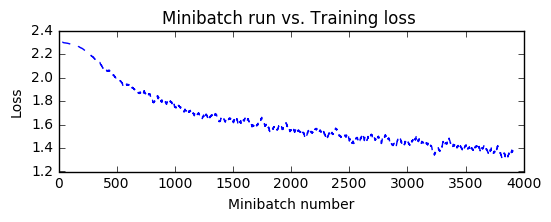

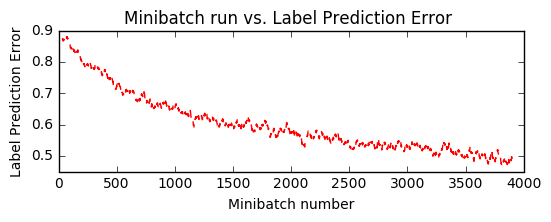

In [29]:
pred = train_and_evaluate(reader_train, 
                          reader_test, 
                          max_epochs=5, 
                          model_func=create_basic_model)

Although, this model is very simple, it still has too much code, we can do better. Here the same model in more terse format:

Training 985898 parameters in 10 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per sample: 0.9983550962823424
Finished Epoch[1 of 10]: [Training] loss = 2.078778 * 50000, metric = 76.40% * 50000 107.172s (466.5 samples/s);
Finished Epoch[2 of 10]: [Training] loss = 1.724720 * 50000, metric = 64.12% * 50000 103.509s (483.0 samples/s);
Finished Epoch[3 of 10]: [Training] loss = 1.578155 * 50000, metric = 58.13% * 50000 104.081s (480.4 samples/s);
Finished Epoch[4 of 10]: [Training] loss = 1.464906 * 50000, metric = 53.26% * 50000 104.524s (478.4 samples/s);
Finished Epoch[5 of 10]: [Training] loss = 1.378042 * 50000, metric = 49.59% * 50000 104.150s (480.1 samples/s);
Finished Epoch[6 of 10]: [Training] loss = 1.303519 * 50000, metric = 46.87% * 50000 104.961s (476.4 samples/s);
Finished Epoch[7 of 10]: [Training] loss = 1.222369 * 50000, metric = 43.55% * 50000 104.190s (479.9 samples/s);
Finished Epoch[8 of 10]: [Training] loss = 1.164991 * 50000, metric = 41.33% * 500

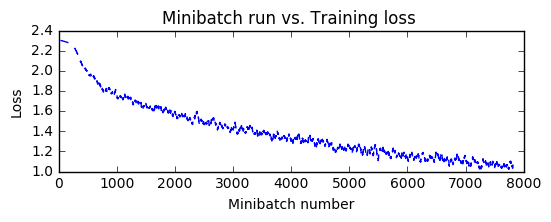

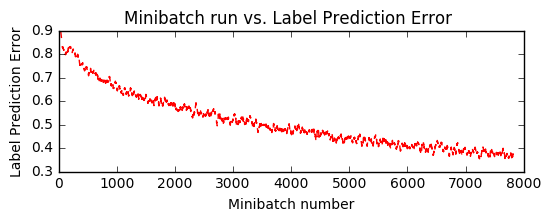

In [79]:
def create_basic_model_terse(input, out_dims):

    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        model = C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((5,5), [1024,32,64][i], pad=True, name='filters'+str(i)),
                C.layers.MaxPooling((3,3), strides=(2,2))
                ]),
            C.layers.Dense(64),
            C.layers.Dense(out_dims, activation=None)
        ])

    return model(input)
pred_basic_model = train_and_evaluate(reader_train, 
                                      reader_test, 
                                      max_epochs=10, 
                                      model_func=create_basic_model_terse)

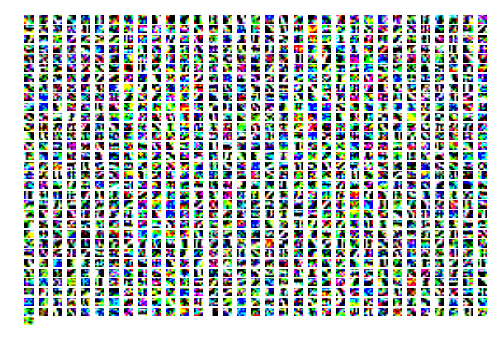

In [81]:
def ShapeFilter(f):
    nf = np.ndarray(shape=(f.shape[1],f.shape[2],f.shape[0]))
    for k in range(f.shape[0]):
        for i in range(f.shape[1]):
            for j in range(f.shape[2]):
                nf[i,j,k]=f[k,i,j]
    return nf

fig = plt.figure()
layer = pred_basic_model.parameters[-2].value
nrows = int(math.sqrt(layer.shape[0]))
ncols = int(layer.shape[0]/nrows)+1

for i in range(layer.shape[0]):
    fig.add_subplot(nrows,ncols,i+1)
    plt.imshow(ShapeFilter(layer[i,:,:,:]))
    plt.axis('off')
#plt.title('Layer '+str(k))
plt.show()

In [187]:
D = np.ones((1024,1024))
for i in range(1024):
    for j in range(1024):
        im0=np.mean(ShapeFilter(layer[i,:,:,:]), axis=2)
        im1=np.mean(ShapeFilter(layer[j,:,:,:]), axis=2)
        R = la.orthogonal_procrustes(im0,im1)
        D[i,j]=la.norm(np.subtract(np.matmul(im0, R[0]), im1),ord='fro')
print('done computing pairwise distances')

done computing pairwise distances


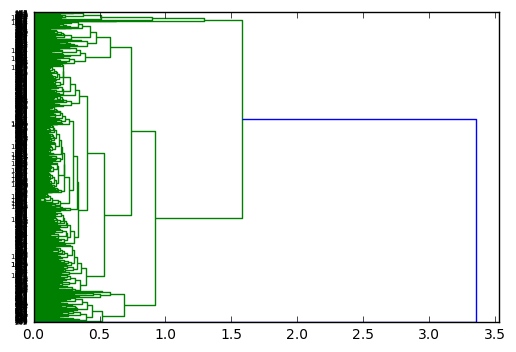

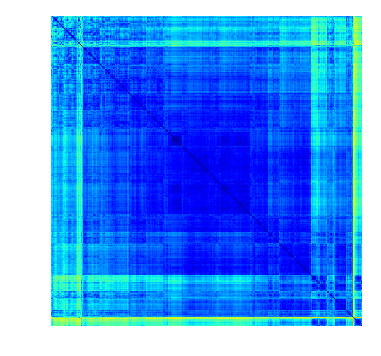

In [188]:
import scipy.cluster.hierarchy as hier
Z = hier.linkage(D, "average")
DG=hier.dendrogram(Z, orientation='right')
index = DG['leaves']
sD = D[index,:]
sD = sD[:,index]
fig = plt.figure()
plt.imshow(sD)
plt.axis('off')
plt.show()

In [189]:
clusts=hier.fcluster(Z, 10, criterion="maxclust")
sizes=[len([idx for idx,c in enumerate(clusts) if c == i]) for i in range(1,11)]

samples_per_clust=8
tclusts=[cid+1 for cid,csize in enumerate(sizes) if csize>samples_per_clust]

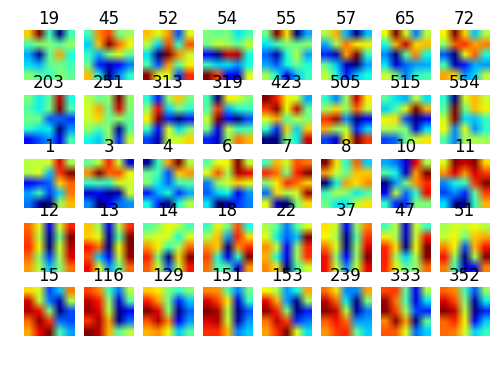

In [210]:
fig = plt.figure()
tcid=-1
for cid in tclusts:
    tcid+=1
    samples = [idx for idx,c in enumerate(clusts) if c == cid]
    for sampleid in range(samples_per_clust):
        imid0=samples[0]
        imid=samples[sampleid+1]
        im0=np.mean(ShapeFilter(layer[imid0,:,:,:]), axis=2)
        im1=np.mean(ShapeFilter(layer[imid ,:,:,:]), axis=2)
        R = la.orthogonal_procrustes(im1,im0)
        im1_r=np.matmul(im1, R[0])
        fig.add_subplot(len(tclusts),samples_per_clust,tcid*samples_per_clust + sampleid+1)
        #plt.title(str(imid))
        plt.imshow(im1_r)
        plt.axis('off')
plt.show()

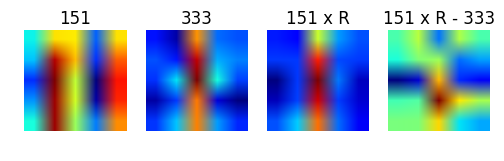

In [214]:
#most_similar=np.unravel_index(np.argmin(D+np.eye(D.shape[0],D.shape[1])), D.shape)
#idx0=most_similar[0]
#idx1=most_similar[1]
idx0=151
idx1=333
im0=np.mean(ShapeFilter(layer[idx0,:,:,:]),axis=2)
im1=np.mean(ShapeFilter(layer[idx1,:,:,:]),axis=2)
R = la.orthogonal_procrustes(im0,im1)

fig = plt.figure()
fig.add_subplot(1,4,1)
plt.imshow(im0)
plt.title(str(idx0))
plt.axis('off')
fig.add_subplot(1,4,2)
plt.imshow(im1)
plt.title(str(idx1))
plt.axis('off')
fig.add_subplot(1,4,3)
plt.imshow(np.matmul(im0, R[0]))
plt.title(str(idx0) + ' x R')
plt.axis('off')
fig.add_subplot(1,4,4)
plt.imshow(np.subtract(np.matmul(im0, R[0]), im1))
plt.title(str(idx0) + ' x R - '+str(idx1))
plt.axis('off')
plt.show()

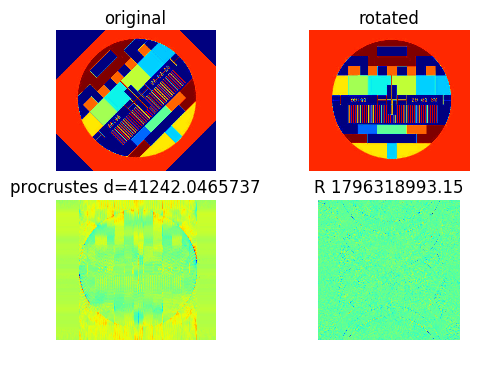

In [258]:
url='https://img0.etsystatic.com/045/0/8715327/il_570xN.670240336_jft4.jpg'
from PIL import Image
import requests
from io import BytesIO
response = requests.get(url)
img = Image.open(BytesIO(response.content))
im_mean = np.mean(im0)
im0 = np.mean(np.array(img.rotate(45)),axis=2)
im1 = np.mean(np.array(img),axis=2)
im0 -= np.mean(im0)
im1 -= np.mean(im1)
R = la.orthogonal_procrustes(im0,im1)
fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(im0)
plt.title('original')
plt.axis('off')
fig.add_subplot(2,2,2)
plt.imshow(im1)
plt.title('rotated')
plt.axis('off')
fig.add_subplot(2,2,3)
plt.imshow(np.dot(im0, R[0]))
plt.title('procrustes d=' +str(la.norm(np.subtract(np.dot(im0, R[0]),im1),ord='fro')))
plt.axis('off')
fig.add_subplot(2,2,4)
plt.imshow(R[0])
plt.title('R '+str(R[1]))
plt.axis('off')
plt.show()

In [248]:
np.mean(im0)

1.8203823918108943e-14

In [26]:
kernels = dict((p.uid,p.value) for p in pred_basic_model.parameters if len(p.shape) == 4)

kernels

{'Parameter555': array([[[[  2.39417292e-02,   5.05634695e-02,  -5.23355938e-02,
             6.89778198e-03,  -7.22344592e-02],
          [  2.65773633e-05,  -6.62465394e-02,  -1.07634421e-02,
            -8.64742920e-02,  -5.97098507e-02],
          [ -6.94595575e-02,   7.09185600e-02,   1.46833379e-02,
            -3.51637341e-02,   5.56818917e-02],
          [  6.09987229e-02,   1.11844040e-01,   9.36384872e-02,
             5.13478070e-02,   1.00434877e-01],
          [  2.03820392e-02,   2.37810835e-02,   4.86655124e-02,
            -3.91579047e-02,  -3.05855013e-02]],
 
         [[ -4.03480604e-02,  -8.23336318e-02,  -6.58527911e-02,
            -8.72577727e-02,   3.35219665e-03],
          [ -9.05144736e-02,  -1.00671545e-01,  -1.23820230e-01,
            -4.02628407e-02,  -1.27983376e-01],
          [  2.78664823e-03,   2.87091546e-02,   1.49904098e-02,
             1.00046597e-01,  -1.74462534e-02],
          [  1.79712046e-02,   1.19955793e-01,   2.03858048e-01,
            

In [80]:
def create_alexnet(input, out_dims):
    def LocalResponseNormalization(k, n, alpha, beta, name=''):
        x = C.placeholder(name='lrn_arg')
        x2 = C.square(x)
        # reshape to insert a fake singleton reduction dimension after the 3th axis (channel axis). Note Python axis order and BrainScript are reversed.
        x2s = C.reshape(x2, (1, C.InferredDimension), 0, 1)
        W = C.constant(alpha/(2*n+1), (1,2*n+1,1,1), name='W')
        # 3D convolution with a filter that has a non 1-size only in the 3rd axis, and does not reduce since the reduction dimension is fake and 1
        y = C.convolution (W, x2s)
        # reshape back to remove the fake singleton reduction dimension
        b = C.reshape(y, C.InferredDimension, 0, 2)
        den = C.exp(beta * C.log(k + b))
        apply_x = C.element_divide(x, den)
        return apply_x
    
    with C.layers.default_options(activation=None, pad=True, bias=True):
        model = C.layers.Sequential([
            # we separate Convolution and ReLU to name the output for feature extraction (usually before ReLU) 
            C.layers.Convolution2D((11,11), 96, init=C.initializer.normal(0.01), pad=False, strides=(4,4), name='conv1'),
            C.layers.Activation(activation=relu, name='relu1'),
            LocalResponseNormalization(1.0, 2, 0.0001, 0.75, name='norm1'),
            C.layers.MaxPooling((3,3), (2,2), name='pool1'),

            C.layers.Convolution2D((5,5), 192, init=C.initializer.normal(0.01), init_bias=0.1, name='conv2'), 
            C.layers.Activation(activation=relu, name='relu2'),
            LocalResponseNormalization(1.0, 2, 0.0001, 0.75, name='norm2'),
            C.layers.MaxPooling((3,3), (2,2), name='pool2'),

            C.layers.Convolution2D((3,3), 384, init=C.initializer.normal(0.01), name='conv3'), 
            C.layers.Activation(activation=relu, name='relu3'),
            C.layers.Convolution2D((3,3), 384, init=C.initializer.normal(0.01), init_bias=0.1, name='conv4'), 
            C.layers.Activation(activation=relu, name='relu4'),
            C.layers.Convolution2D((3,3), 256, init=C.initializer.normal(0.01), init_bias=0.1, name='conv5'), 
            C.layers.Activation(activation=relu, name='relu5'), 
            C.layers.MaxPooling((3,3), (2,2), name='pool5'), 

            C.layers.Dense(4096, init=C.initializer.normal(0.005), init_bias=0.1, name='fc6'),
            C.layers.Activation(activation=relu, name='relu6'),
            C.layers.Dropout(0.5, name='drop6'),
            C.layers.Dense(4096, init=C.initializer.normal(0.005), init_bias=0.1, name='fc7'),
            C.layers.Activation(activation=relu, name='relu7'),
            C.layers.Dropout(0.5, name='drop7'),
            C.layers.Dense(out_dims, init=C.initializer.normal(0.01), name='fc8')
            ])
    return model(input)

pred_alexnet = train_and_evaluate(reader_train, 
                                      reader_test, 
                                      max_epochs=10, 
                                      model_func=create_alexnet)

ValueError: Convolution operation requires that kernel dim 5 <= input dim 3.

[CALL STACK]
    > Microsoft::MSR::CNTK::DataTransferer::  operator=
    - CNTK::NDMask::  MaskedCount
    - CNTK::NDMask::  MaskedCount
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::Function::  ReplacePlaceholders
    - CNTK::  Hardmax
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::  Unpooling
    - CNTK::  Unpooling



Now that we have a trained model, let us classify the following image of a truck. We use PIL to read the image.

In [16]:
# Figure 6
Image(url="https://cntk.ai/jup/201/00014.png", width=64, height=64)

In [17]:
# Download a sample image 
# (this is 00014.png from test dataset)
# Any image of size 32,32 can be evaluated

url = "https://cntk.ai/jup/201/00014.png"
myimg = np.array(PIL.Image.open(urlopen(url)), dtype=np.float32)

During training we have subtracted the mean from the input images. Here we take an approximate value of the mean and subtract it from the image.

In [18]:
def eval(pred_op, image_data):
    label_lookup = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    image_mean = 133.0
    image_data -= image_mean
    image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))
    
    result = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))
    
    # Return top 3 results:
    top_count = 3
    result_indices = (-np.array(result)).argsort()[:top_count]

    print("Top 3 predictions:")
    for i in range(top_count):
        print("\tLabel: {:10s}, confidence: {:.2f}%".format(label_lookup[result_indices[i]], result[result_indices[i]] * 100))

In [19]:
# Run the evaluation on the downloaded image
eval(pred_basic_model, myimg)

Top 3 predictions:
	Label: truck     , confidence: 96.59%
	Label: ship      , confidence: 2.31%
	Label: cat       , confidence: 0.43%


Adding dropout layer, with drop rate of 0.25, before the last dense layer:

In [20]:
def create_basic_model_with_dropout(input, out_dims):

    with C.layers.default_options(activation=C.relu, init=C.glorot_uniform()):
        model = C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((5,5), [32,32,64][i], pad=True),
                C.layers.MaxPooling((3,3), strides=(2,2))
            ]),
            C.layers.Dense(64),
            C.layers.Dropout(0.25),
            C.layers.Dense(out_dims, activation=None)
        ])

    return model(input)

Training 116906 parameters in 10 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per sample: 0.9983550962823424
Finished Epoch[1 of 5]: [Training] loss = 2.107245 * 50000, metric = 79.08% * 50000 12.977s (3853.0 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 1.795581 * 50000, metric = 67.10% * 50000 12.244s (4083.6 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 1.657041 * 50000, metric = 61.52% * 50000 12.265s (4076.6 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 1.567592 * 50000, metric = 57.72% * 50000 12.251s (4081.3 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 1.500142 * 50000, metric = 54.97% * 50000 12.228s (4089.0 samples/s);

Final Results: Minibatch[1-626]: errs = 47.1% * 10000



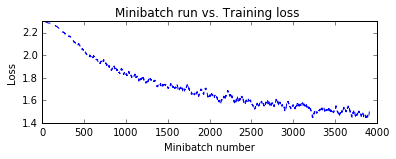

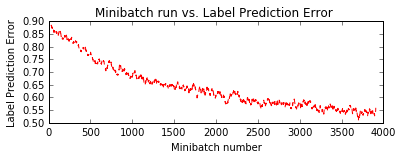

In [21]:
pred_basic_model_dropout = train_and_evaluate(reader_train, 
                                              reader_test, 
                                              max_epochs=5, 
                                              model_func=create_basic_model_with_dropout)

Add batch normalization after each convolution and before the last dense layer:

In [22]:
def create_basic_model_with_batch_normalization(input, out_dims):

    with C.layers.default_options(activation=C.relu, init=C.glorot_uniform()):
        model = C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((5,5), [32,32,64][i], pad=True),
                C.layers.BatchNormalization(map_rank=1),
                C.layers.MaxPooling((3,3), strides=(2,2))
            ]),
            C.layers.Dense(64),
            C.layers.BatchNormalization(map_rank=1),
            C.layers.Dense(out_dims, activation=None)
        ])

    return model(input)

Training 117290 parameters in 18 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per sample: 0.9983550962823424
Finished Epoch[1 of 5]: [Training] loss = 1.536584 * 50000, metric = 55.22% * 50000 12.978s (3852.7 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 1.215455 * 50000, metric = 43.35% * 50000 12.196s (4099.7 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 1.092067 * 50000, metric = 38.66% * 50000 12.260s (4078.3 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 1.011021 * 50000, metric = 35.57% * 50000 12.330s (4055.2 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 0.952613 * 50000, metric = 33.38% * 50000 12.286s (4069.7 samples/s);

Final Results: Minibatch[1-626]: errs = 30.1% * 10000



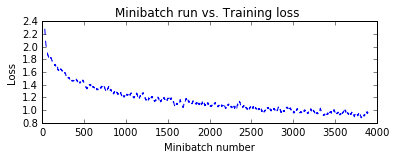

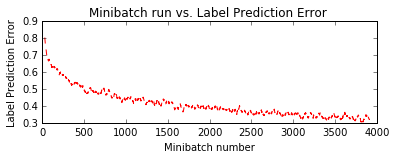

In [23]:
pred_basic_model_bn = train_and_evaluate(reader_train, 
                                         reader_test, 
                                         max_epochs=5, 
                                         model_func=create_basic_model_with_batch_normalization)

Let's implement an inspired VGG style network, using layer API, here the architecture:

| VGG9          |
| ------------- |
| conv3-64      |
| conv3-64      |
| max3          |
|               |
| conv3-96      |
| conv3-96      |
| max3          |
|               |
| conv3-128     |
| conv3-128     |
| max3          |
|               |
| FC-1024       |
| FC-1024       |
|               |
| FC-10         |


In [24]:
def create_vgg9_model(input, out_dims):
    with C.layers.default_options(activation=C.relu, init=C.glorot_uniform()):
        model = C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((3,3), [64,96,128][i], pad=True),
                C.layers.Convolution((3,3), [64,96,128][i], pad=True),
                C.layers.MaxPooling((3,3), strides=(2,2))
            ]),
            C.layers.For(range(2), lambda : [
                C.layers.Dense(1024)
            ]),
            C.layers.Dense(out_dims, activation=None)
        ])
        
    return model(input)

Training 2675978 parameters in 18 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per sample: 0.9983550962823424
Finished Epoch[1 of 5]: [Training] loss = 2.267064 * 50000, metric = 84.67% * 50000 18.672s (2677.8 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 1.877782 * 50000, metric = 69.81% * 50000 12.578s (3975.2 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 1.689757 * 50000, metric = 63.07% * 50000 12.729s (3928.0 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 1.564912 * 50000, metric = 57.57% * 50000 12.536s (3988.5 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 1.475126 * 50000, metric = 53.79% * 50000 13.171s (3796.2 samples/s);

Final Results: Minibatch[1-626]: errs = 50.1% * 10000



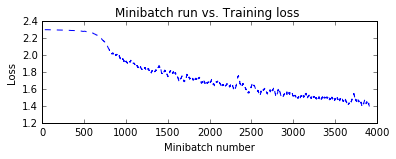

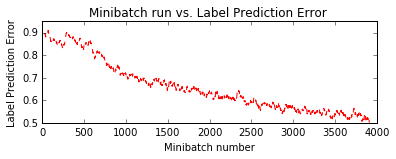

In [25]:
pred_vgg = train_and_evaluate(reader_train, 
                              reader_test, 
                              max_epochs=5, 
                              model_func=create_vgg9_model)

### Residual Network (ResNet)

One of the main problem of a Deep Neural Network is how to propagate the error all the way to the first layer. For a deep network, the gradients keep getting smaller until it has no effect on the network weights. [ResNet](https://arxiv.org/abs/1512.03385) was designed to overcome such problem, by defining a block with identity path, as shown below:

In [26]:
# Figure 7
Image(url="https://cntk.ai/jup/201/ResNetBlock2.png")

The idea of the above block is 2 folds:

* During back propagation the gradients have a path that does not affect its magnitude.
* The network need to learn residual mapping (delta to x).

So let's implements ResNet blocks using CNTK:

            ResNetNode                   ResNetNodeInc
                |                              |
         +------+------+             +---------+----------+
         |             |             |                    |
         V             |             V                    V
    +----------+       |      +--------------+   +----------------+
    | Conv, BN |       |      | Conv x 2, BN |   | SubSample, BN  |
    +----------+       |      +--------------+   +----------------+
         |             |             |                    |
         V             |             V                    |
     +-------+         |         +-------+                |
     | ReLU  |         |         | ReLU  |                |
     +-------+         |         +-------+                |
         |             |             |                    |
         V             |             V                    |
    +----------+       |        +----------+              |
    | Conv, BN |       |        | Conv, BN |              |
    +----------+       |        +----------+              |
         |             |             |                    |
         |    +---+    |             |       +---+        |
         +--->| + |<---+             +------>+ + +<-------+
              +---+                          +---+
                |                              |
                V                              V
            +-------+                      +-------+
            | ReLU  |                      | ReLU  |
            +-------+                      +-------+
                |                              |
                V                              V


In [27]:
def convolution_bn(input, filter_size, num_filters, strides=(1,1), init=C.he_normal(), activation=C.relu):
    if activation is None:
        activation = lambda x: x
        
    r = C.layers.Convolution(filter_size, 
                             num_filters, 
                             strides=strides, 
                             init=init, 
                             activation=None, 
                             pad=True, bias=False)(input)
    r = C.layers.BatchNormalization(map_rank=1)(r)
    r = activation(r)
    
    return r

def resnet_basic(input, num_filters):
    c1 = convolution_bn(input, (3,3), num_filters)
    c2 = convolution_bn(c1, (3,3), num_filters, activation=None)
    p  = c2 + input
    return C.relu(p)

def resnet_basic_inc(input, num_filters):
    c1 = convolution_bn(input, (3,3), num_filters, strides=(2,2))
    c2 = convolution_bn(c1, (3,3), num_filters, activation=None)

    s = convolution_bn(input, (1,1), num_filters, strides=(2,2), activation=None)
    
    p = c2 + s
    return C.relu(p)

def resnet_basic_stack(input, num_filters, num_stack):
    assert (num_stack > 0)
    
    r = input
    for _ in range(num_stack):
        r = resnet_basic(r, num_filters)
    return r

Let's write the full model:

In [28]:
def create_resnet_model(input, out_dims):
    conv = convolution_bn(input, (3,3), 16)
    r1_1 = resnet_basic_stack(conv, 16, 3)

    r2_1 = resnet_basic_inc(r1_1, 32)
    r2_2 = resnet_basic_stack(r2_1, 32, 2)

    r3_1 = resnet_basic_inc(r2_2, 64)
    r3_2 = resnet_basic_stack(r3_1, 64, 2)

    # Global average pooling
    pool = C.layers.AveragePooling(filter_shape=(8,8), strides=(1,1))(r3_2)    
    net = C.layers.Dense(out_dims, init=C.he_normal(), activation=None)(pool)
    
    return net

Training 272474 parameters in 65 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per sample: 0.9983550962823424
Finished Epoch[1 of 5]: [Training] loss = 1.895607 * 50000, metric = 70.00% * 50000 24.547s (2036.9 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 1.594962 * 50000, metric = 59.18% * 50000 21.075s (2372.5 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 1.456406 * 50000, metric = 53.31% * 50000 21.631s (2311.5 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 1.354717 * 50000, metric = 49.36% * 50000 20.848s (2398.3 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 1.275108 * 50000, metric = 45.98% * 50000 21.164s (2362.5 samples/s);

Final Results: Minibatch[1-626]: errs = 43.9% * 10000



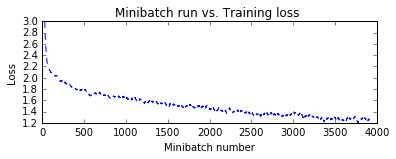

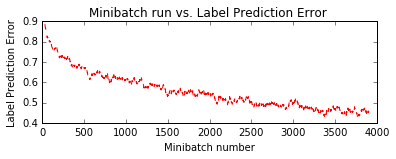

In [29]:
pred_resnet = train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_resnet_model)